In [ ]:
! pip install segmentation_models_pytorch albumentations
! pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import albumentations
import torchvision 
import random
import segmentation_models_pytorch as smp
import sys

In [ ]:
#Mount Google Drive with dataset
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks')
import hist_consistency

In [ ]:
class PSD():
    """
    Class used to predict binary masks of images, measure pore areas, export them into csv-file and plot histogram
    
    Attributes
    ----------
    path_images: str.
        Path to directory with raw images.
    path_hdrs: str.
        Path to directory with hdr-files containing pixel size.
    imgpathes: list of str.
        Pathes to raw images.
    hdrpathes: list of str.
        Pathes to hdr-files.
    model: model class of Segmentation Models library.
        Model to predict binary mask of image.
    areas: ndarray(dtype='float32') of shape (N, ).
        Array of area values (in squared microns) of all connectned regions (pores).
    """

    def __init__(self, path_images, path_hdrs, model):
        self.path_images = path_images
        self.path_hdrs = path_hdrs
        #Collect all pathes to images and hdrs in two lists
        self.imgpathes = sorted([os.path.join(path_images, i) for i in os.listdir(path_images)])
        self.hdrpathes = sorted([os.path.join(path_hdrs, i) for i in os.listdir(path_hdrs)])
        self.model = model
        self.areas = None
        #Check out size of dataset
        print('Number of images =', len(self.imgpathes))
        print('Number of hdr-files =', len(self.hdrpathes))


    def area_all(self):
        """
        Predicts binary masks of all images and measures area (in squared microns) of all connected regions (pores).
    
        Returns
        -------
        ndarray(dtype='float32') of shape (N, ).
            Array of area values (in squared microns) of all connectned regions (pores).
        """

        areas = []
        for i in range(len(self.imgpathes)):
            mask = self.__predict(self.imgpathes[i])
            area = hist_consistency.area(mask)
            area = self.__px_size(self.hdrpathes[i]) * area.astype('float32')
            areas.append(area)
            self.areas = np.concatenate(areas)
        return self.areas


    def hist(self, bins=100, lrange=0., rrange=None):
        """
        Plots histogram of pore area values.
    
        Parameters
        ----------
        bins: int, optional, default=100.
            Number of bins.
        lrange: float, optional, default=0.
            Left boundary of histogram.
        rrange: float, optional, default=max pore area.
            Right boundary of histogram.
        """

        if not rrange:
            rrange = self.areas.max().item()
        plt.hist(self.areas[np.where((self.areas >= lrange) & (self.areas <= rrange), True, False)], bins=bins, color='r')
        plt.xlabel('Area, mu^2')
        plt.ylabel('Counts')
        plt.show()
        return None


    def save(self):
        """
        Exports pore area values (in squared microns) to csv-file (in one column manner)
        located in directory with folders "images" and "hdrs". 
        """

        np.savetxt(self.path_images.replace('images/', 'result.csv'), self.areas.reshape(-1, 1), fmt='%.7E')
        return None


    def __predict(self, imgpath):
        """
        Private function.
        Predicts binary mask of raw image of shape (H, W) with any size.

        Parameters
        ----------
        imgpath: str.
            Path to raw image.
        
        Returns
        -------
        ndarray(dtype='uint8) of shape (H, W).
            Binary mask with black pores (pixel=0) and white background (pixel=1).
        """

        img = plt.imread(imgpath)
        H, W = img.shape
        H_pad_width, W_pad_width = (512 - H % 512) * bool(H % 512), (512 - W % 512) * bool(W % 512)
        img_pad = np.pad(img, ((0, H_pad_width), (0, W_pad_width)), mode='constant', constant_values=255)
        mask_pad = np.zeros_like(img_pad)

        for h in range((H + H_pad_width) // 512):
            for w in range((W + W_pad_width) // 512):
                img_input = img_pad[h * 512 : (h + 1) * 512, w * 512 : (w + 1) * 512]
                mask_pad[h * 512 : (h + 1) * 512, w * 512 : (w + 1) * 512] = self.__predict_chunk(img_input)
        mask = mask_pad[:H, :W]
        return mask


    def __predict_chunk(self, img):
        """
        Private function.
        Predicts binary mask of raw image chunk of shape (512, 512).

        Parameters
        ----------
        img: ndarray(dtype='uint8') of shape (512, 512).
            Chunk of raw image.
        
        Returns
        -------
        ndarray(dtype='uint8) of shape (512, 512).
            Binary mask with black pores (pixel=0) and white background (pixel=1).
        """

        img_input = self.__convert_to_tensor(img)
        img_input = torch.from_numpy(img_input).to(device).unsqueeze(0)
        mask = self.model.predict(img_input)
        mask = mask.squeeze().cpu().detach().numpy().round().astype('uint8')
        mask = hist_consistency.postproc(mask, sure_fg_threshold=0.55)
        return mask


    def __convert_to_tensor(self, x):
        """
        Private function.
        Reshape numpy tensor from (H, W) to (C=1, H, W).
    
        Parameters
        ----------
        x: ndarray of shape (H, W).
            Image in tensor form.

        Returns
        -------
        ndarray(dtype='float32') of shape (C=1, H, W).
            Reshaped image in tensor form.
        """

        return np.expand_dims(x, axis=0).astype("float32")


    def __px_size(self, hdrpath):
        """
        Private function.
        Reads hdr-file and returns (in squared microns) pixel size of raw image.

        Parameters
        ----------
        hdrpath: str.
            Path to hdr-file.
        
        Returns
        -------
        float.
            Area of one pixel.
        """

        with open(hdrpath) as hdr:
            hdr.readline()
            tag = ''
            while tag != 'PixelSizeX':
                line = hdr.readline().strip()
                items = line.split('=')
                tag = items[0]
            return((float(items[1]) * 1000000) ** 2)    

In [ ]:
#Define encoder, activation function, device and path to model weights
encoder = 'efficientnet-b4'
activation = 'sigmoid'
device = "cuda"
modelpath = '/content/drive/MyDrive/best_model_FPN_efficientnet-b4_ep100_bs11_wc_wlrsch_lr0_001_imagenet.pth'

#Define model and load model weights
model = smp.FPN(encoder_name=encoder, activation=activation, encoder_weights=None, encoder_depth=5, in_channels=1)
model.load_state_dict(torch.load(modelpath))
model.to(device)

In [ ]:
#Define pathes to images and corresponding hdr-files
path_images = '/content/drive/MyDrive/working_dir/images/'
path_hdrs = '/content/drive/MyDrive/working_dir/hdrs/'
#Initialize object of PSD-class and check out dataset size.
ex = PSD(path_images, path_hdrs, model)

Number of images = 10
Number of hdr-files = 10


In [ ]:
#Measure pore areas
ex.area_all();

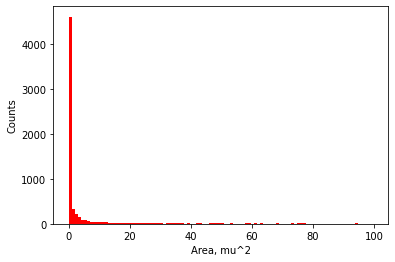

In [ ]:
#Plot histogram of pore areas
ex.hist(100, 0, 100)

In [ ]:
#Save pore areas to csv-file
ex.save()